In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.autonotebook import tqdm

<ipython-input-1-11d3c87b2a5c>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Задача № 1, Вариант № 7:
\begin{equation*}
 \begin{cases}
   \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + 
   0,5 \exp{(-0,5t)}\cos{x},
   \\
   u_{x}(0,t)=\exp{(-0,5t)},
   \\
   u_{x}(\pi,t)= -\exp{(-0,5t)},
   \\
   u(x,0)=\sin{x}
 \end{cases}
\end{equation*}

In [2]:
dt = 0.0005
dx = 0.1
start_x = 0
stop_x = math.pi
start_t = 0
stop_t = 4

#### Аналитическое решение

\begin{equation*}
    U(x,t)=\exp{(-0,5t)}\sin x
\end{equation*}

Text(0.5, 0, 'x')

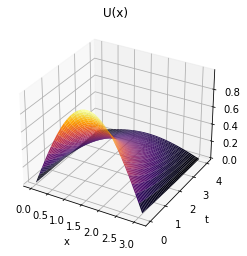

In [3]:
x_coord = np.arange(start_x, stop_x,dx)
t_coord = np.arange(start_t, stop_t,dt)
x_coord, t_coord = np.meshgrid(x_coord, t_coord)
solve_an = np.exp(-0.5*t_coord)*np.sin(x_coord)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_coord, t_coord, solve_an, cmap='inferno')
plt.title("U(x)")
plt.ylabel('t')
plt.xlabel('x')
#ax.scatter(x_coord, t_coord, solve_an, s=1)

### Функции решателя

#### Решение явной схемой

\begin{equation*}
   u_{n,k+1} -  u_{n,k}= \frac{dt}{dx^2}( u_{n-1,k} - 2u_{n,k}+u_{n+1,k}) + dt*0,5 \exp{(-0,5t)}\cos{x} )
\end{equation*}

In [4]:
x = np.arange(start_x, stop_x,dx)
t = np.arange(start_t, stop_t,dt)
u_yavn = np.zeros((x.shape[0],t.shape[0]))
    
for i in range(x.shape[0]):
    u_yavn[i][0]=np.sin(x[i])

In [5]:
def f1(t):
    return np.exp(-0.5*t)

def f2(t):
    return -1*np.exp(-0.5*t)

In [6]:
for t_i in range(t.shape[0]-1):
    for x_i in range(1, x.shape[0]-1):
        #print((u_yavn[x_i-1][t_i]-2*u_yavn[x_i][t_i]+u_yavn[x_i+1][t_i]))
        u_yavn[x_i][t_i+1] = u_yavn[x_i][t_i]+ \
            dt*(u_yavn[x_i-1][t_i]-2*u_yavn[x_i][t_i]+u_yavn[x_i+1][t_i])/(dx*dx)+ \
            dt*0.5*np.exp(-0.5*t[t_i])*np.cos(x[x_i])
    u_yavn[0][t_i] = -1*f1(t_i)*dx + u_yavn[1][t_i]
    u_yavn[x.shape[0]-1][t_i] = f2(t_i)*dx + u_yavn[x.shape[0]-2][t_i]
        
u_yavn =  np.transpose(u_yavn)

In [7]:
# xx, tt = np.meshgrid(x, t)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xx, tt,  u_yavn, cmap='inferno')

### Использование решателя

In [42]:
def neodn(x, t):
    return 0.5*np.exp(-0.5*t)*np.sin(x)
    #return 0.5*np.exp(-0.5*t)*np.cos(x)
    #return 0


def test_func(x, t):
    return np.exp(-0.5*t)*np.sin(x)


def layer_0(X, A1, B1, G1, n):
    U = []
    for x in X:
        U.append(np.sin(x))

    return U


def init_boundary_values(t):
    alpha = 1
    beta = 0
    gamma = 1
    delta = 0
    phi_0 = np.exp(-0.5*t)
    phi_N = -np.exp(-0.5*t)

    return alpha, beta, gamma, delta, phi_0, phi_N


def tm_alg(A, B, C, D, n):
    Q, P, X = [], [], [0] * n
    Q.append(C[0] / B[0])
    P.append(D[0] / B[0])

    for i in range(1, n):
        ZN = B[i] - A[i]*Q[i-1]

        if ZN == 0:
            print('Error!')
            return -1

        Q.append(C[i] / ZN)
        P.append((D[i] - A[i]*P[i-1]) / ZN)

    for i in range(n - 1, -1, -1):
        if i == n - 1:
            X[i] = P[i]
        else:
            X[i] = P[i] - Q[i] * X[i + 1]

    return X

In [43]:

def eq_sol(S, IPR, X0, XN, DX, n, TI, TIM, DT, A1, B1, C1, SIG):
    """
    Основной блок решателя
    """
    X = np.linspace(X0, XN, n)
    U, UA, UN = [], [], []
    eps = []
    
    #Выходная матрица
    U_matrix = np.zeros((n,int(TIM / DT)))
    line = 0

    # Задание начальных данных
    US = layer_0(X, A1, B1, C1, n)
    
    for i in range(n):
        # Аппроксимация начального условия
        U.append(US[i])

    NSM = int(TIM / DT)
    NS = 0
    
    UA.clear()
    NS += 1
    TI += DT
    
    AK=A1*DT/(DX*DX)
    BK=B1*DT/DX
    CK = C1*DT
    
    # Основной цикл по времени
    for NS in range(NSM):
        TI0 = TI
        TI += DT
        A, B, C, D = [], [], [], []

        # Задание граничных условий
        AL, BE, GA, DE, FI0, FIN = init_boundary_values(TI)
        
        if IPR == 1:
            # Двухточечная аппроксимация с первым порядком
            A.append(0)
            B.append(AL - BE * DX)
            C.append(-AL)
            D.append( -DX * FI0)
        else:
            # Трехточечная аппроксимация со вторым порядок
            A.append( 0)
            B.append(AL * (2 * A1 / DX + DX / DT - C1 * DX) - BE * (2 * A1 - B1 * DX))
            C.append(-AL * 2 * A1 / DX)
            D.append(AL * DX / DT * (U[0] + neodn(X[0], TI) * DT) - FI0 * (2 * A1 - B1 * DX))
        
        # Расчет прогоночных коэффициентов
        for i in range(1, n - 1):
            A.append(-AK*S + BK*S*(1-SIG))
            B.append(1 + 2*AK*S + BK*S*SIG - BK*S*(1-SIG) - CK*S) 
            C.append(-AK*S - BK*S*SIG)
            D.append(U[i] + (1-S)*(AK*(U[i+1]-2*U[i]+U[i-1]) + BK*(SIG*(U[i+1] - U[i]) + 
                    (1-SIG)*(U[i]-U[i-1])) + CK*U[i]) + 
                    DT*(S*neodn(X[i],TI) + (1-S)*neodn(X[i], TI0))) 
            
        if IPR == 1:
            # Двухточечная аппроксимация с первым порядком
            A.append(-GA)
            B.append(DE * DX + GA)
            C.append(0)
            D.append(DX * FIN)
        else:
            # Трехточечная аппроксимация со вторым порядок
            A.append(-2 * GA * A1 / DX)
            B.append(GA * (2 * A1 / DX + DX / DT - C1 * DX) + DE * (2 * A1 + DX * B1))
            C.append(0)
            D.append(GA * DX / DT * (U[n - 1] + neodn(X[n - 1], TI)*DT) + (2 * A1 + B1 * DX) * FIN)

        UA.clear()

        # Вызов метода прогонки
        UN = tm_alg(A, B, C, D, n)
        if UN == -1:
            print('Error!')
            return -1

        #Заполнение выходной матрицы
        z=0
        for u in UN:
            U_matrix[z][line]=u
            z+=1
        line+=1

        for i in range(n):
            UA.append(test_func(X[i], TI))
            eps.append(abs(UN[i] - US[i]))

        # Переход к расчета нового слоя по времени
        for i in range(n):
            US[i] = U[i]
            U[i] = UN[i]

    return UN, UA, eps, U_matrix



In [44]:
IPR = 0 # Выбор аппроксимации
X0 = 0 #Границы по X
XN = np.pi
N = 50
T0 = 0 #Границы по T
TN = 2
A1 = 1 #Коэффициенты для уравнения
B1 = 0
C1 = 0
DX = (XN - X0) / (N - 1)
DT = ((0.9*DX)**2)/(2*A1)
SIG =(A1*DT)/(DX**2)

print("dx= ", DX)
print("dt= ", DT)
print("sigma= ", SIG)

U, UA, eps, U_matr = eq_sol(1, IPR, X0, XN, DX, N, T0, TN, DT, A1, B1, C1, SIG)
U2, UA, eps2, U_matr2 = eq_sol(0.5, IPR, X0, XN, DX, N, T0, TN, DT, A1, B1, C1, SIG)
U3, UA, eps3, U_matr3 = eq_sol(0, IPR, X0, XN, DX, N, T0, TN, DT, A1, B1, C1, SIG)
X = np.linspace(X0, XN, N)
f = test_func(X, TN)

n_err = np.linspace(10, N, 6)
d = {}
err1, err2, err3 = [], [], []
h_err = []

for i in tqdm(n_err):
    h = abs(XN - X0) / (i - 1)
    DT = ((0.9*DX)**2)/(2*A1)
    SIG =(A1*DT)/(DX**2)
    U1, UA, epst1, temp = eq_sol(1, IPR, X0, XN, h, int(i), T0, TN, DT, A1, B1, C1, SIG)
    U2, UA, epst2, temp = eq_sol(0.5, IPR, X0, XN, h, int(i), T0, TN, DT, A1, B1, C1, SIG)
    U3, UA, epst3, temp = eq_sol(0, IPR, X0, XN, h, int(i), T0, TN, DT, A1, B1, C1, SIG)

    #абсолютная погрешность
    for j in range(len(U1)):
        d = {i: abs(U1[j] - UA[j])}
    err1.append(np.max(d[i]))
    
    for j in range(len(U2)):
        d = {i: abs(U2[j] - UA[j])}
    err2.append(np.max(d[i]))
    
    for j in range(len(U3)):
        d = {i: abs(U3[j] - UA[j])}
    err3.append(np.max(d[i]))
    
#     err1.append(np.max(epst1))
#     err2.append(np.max(epst2))
#     err3.append(np.max(epst3))
    
    
    h_err.append(h)

dx=  0.0641141357875468
dt=  0.0016648020751525152
sigma=  0.40499999999999997


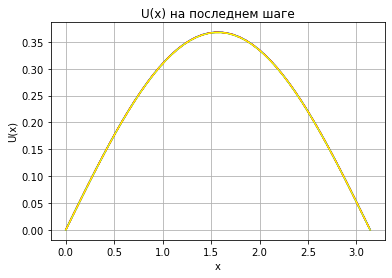

In [45]:
X = np.linspace(X0, XN, N)
plt.plot(X, f, color='green') #Аналитический метод
plt.plot(X, U, color='b') # Неявная схема
plt.plot(X, U2, color='red', ls='--') #Схема Кранка-Николсона
plt.plot(X, U3, color='yellow') # Явная схема
plt.title("U(x) на последнем шаге")
plt.ylabel('U(x)')
plt.xlabel('x')
plt.grid()
plt.show()

### Неявная схема

Text(0.5, 0, 'x')

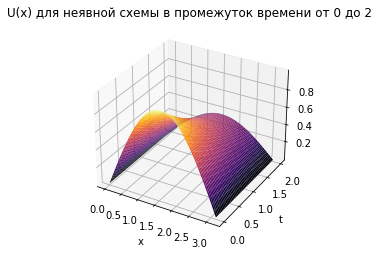

In [46]:
t = np.arange(T0, TN, DT)
if(len(t)>int(TN / DT)):
    t = np.delete(t, len(t)-1)
U_tr = np.transpose(U_matr)
xx, tt = np.meshgrid(X, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, tt,  U_tr, cmap='inferno')

plt.title("U(x) для неявной схемы в промежуток времени от 0 до 2")
plt.ylabel('t')
plt.xlabel('x')

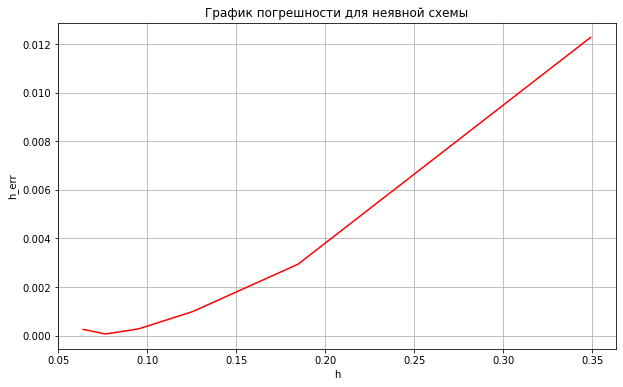

Максимальная погрешность для неявной схемы: 0.01226839577607559


In [47]:
plt.figure(figsize=(10, 6))
plt.plot(h_err, err1, color='red')
plt.title("График погрешности для неявной схемы")
plt.ylabel('h_err')
plt.xlabel('h')
plt.grid()
plt.show()

print("Максимальная погрешность для неявной схемы:", np.max(err1))

### Схема Кранка-Николсона

Text(0.5, 0, 'x')

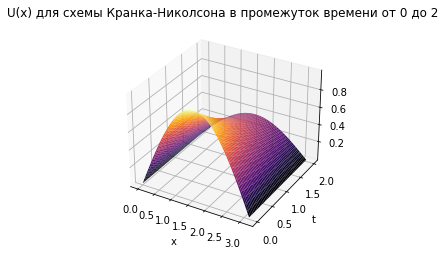

In [48]:
U_tr = np.transpose(U_matr2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, tt,  U_tr, cmap='inferno')

plt.title("U(x) для схемы Кранка-Николсона в промежуток времени от 0 до 2")
plt.ylabel('t')
plt.xlabel('x')

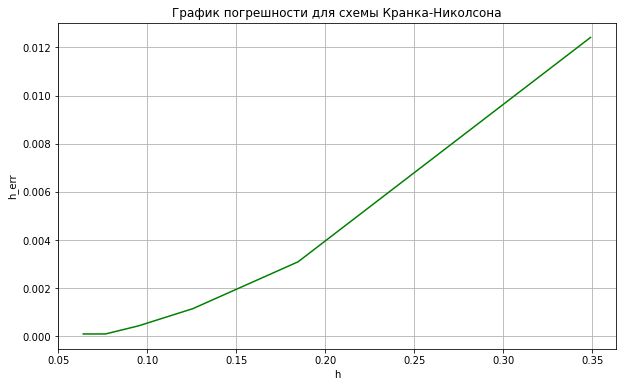

Максимальная погрешность для схемы Кранка-Николсона: 0.012416141438403108


In [49]:
plt.figure(figsize=(10, 6))
plt.plot(h_err, err2, color='green')
plt.title("График погрешности для схемы Кранка-Николсона")
plt.ylabel('h_err')
plt.xlabel('h')
plt.grid()
plt.show()

print("Максимальная погрешность для схемы Кранка-Николсона:", np.max(err2))

### Явная схема

Text(0.5, 0, 'x')

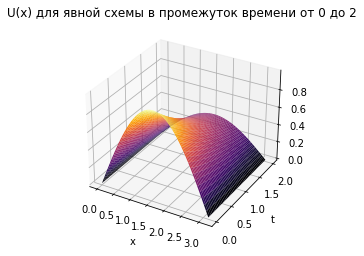

In [50]:
U_tr = np.transpose(U_matr3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, tt,  U_tr, cmap='inferno')

plt.title("U(x) для явной схемы в промежуток времени от 0 до 2")
plt.ylabel('t')
plt.xlabel('x')

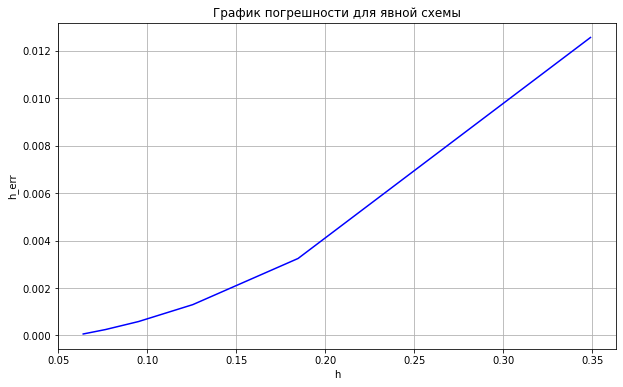

Максимальная погрешность для явной схемы: 0.012563901860886665


In [51]:
plt.figure(figsize=(10, 6))
plt.plot(h_err, err3, color='blue')
plt.title("График погрешности для явной схемы")
plt.ylabel('h_err')
plt.xlabel('h')
plt.grid()
plt.show()

print("Максимальная погрешность для явной схемы:", np.max(err3))